In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import requests
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS
from pyro.infer.predictive import Predictive

from utils import plot_samples

sns.set_palette("Set2")

## Simple Example

In [2]:
p_true = 0.05
N = 1500

occurrences = dist.Bernoulli(torch.ones(N) * p_true).sample()

In [3]:
def binomial_model(occurences):
    p = pyro.sample("p", dist.Uniform(0, 1))
    pyro.sample("occurences", dist.Binomial(total_count=occurrences.shape[0], probs=p), obs=occurences.sum())

In [4]:
nuts_kernel = NUTS(binomial_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(occurrences)

Sample: 100%|██████████| 1200/1200 [00:03, 311.15it/s, step size=1.27e+00, acc. prob=0.938]


In [5]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

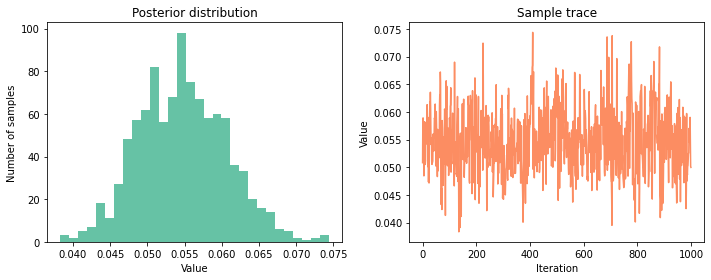

In [6]:
# We get pretty close to p = 0.05
plot_samples(mcmc_samples["p"])

## A/B Testing

In [7]:
# Let's simulate some data for two websites
true_p_A = 0.05
true_p_B = 0.04

N_A = 1500
N_B = 750

observations_A = dist.Bernoulli(torch.ones(N_A) * true_p_A).sample()
observations_B = dist.Bernoulli(torch.ones(N_B) * true_p_B).sample()

In [8]:
# Nothing special, just the same as above now with two inputs


def a_b_testing_model(observations_A, observations_B):
    p_A = pyro.sample("p_A", dist.Uniform(0, 1))
    p_B = pyro.sample("p_B", dist.Uniform(0, 1))

    pyro.sample("observations_A", dist.Bernoulli(p_A), obs=observations_A)
    pyro.sample("observations_B", dist.Bernoulli(p_B), obs=observations_B)

In [9]:
nuts_kernel = NUTS(a_b_testing_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=400)
mcmc.run(observations_A, observations_B)

Sample: 100%|██████████| 2400/2400 [00:14, 161.32it/s, step size=7.24e-01, acc. prob=0.925]


In [10]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
mcmc_samples["delta"] = mcmc_samples["p_A"] - mcmc_samples["p_B"]

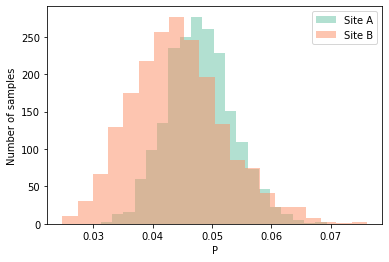

In [11]:
# Site A performs slightly better than site B
fig, ax = plt.subplots()

ax.hist(mcmc_samples["p_A"], label="Site A", alpha=0.5, bins=20)
ax.hist(mcmc_samples["p_B"], label="Site B", alpha=0.5, bins=20)

ax.set_xlabel("P")
ax.set_ylabel("Number of samples")
ax.legend()

plt.show()

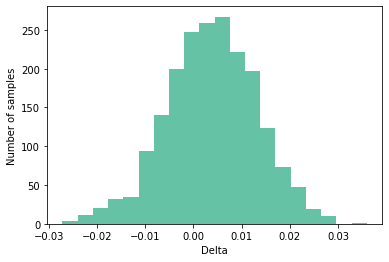

In [12]:
# We expect the true delta around 0.01 but there is also a chance that it is negative
fig, ax = plt.subplots()

ax.hist(mcmc_samples["delta"], bins=20)

ax.set_xlabel("Delta")
ax.set_ylabel("Number of samples")

plt.show()

In [13]:
print(f"Site A performs better with a probability of {(mcmc_samples['delta'] > 0).mean():.1%}")

Site A performs better with a probability of 66.0%


## Cheating Among Students

In [14]:
# The order of the simulated data does not matter for our application
n = 100
n_positive = 35

answers = torch.ones(n)
answers[n_positive:] = 0

In [15]:
def cheating_model(answers):
    p = pyro.sample("p", dist.Uniform(0, 1))

    with pyro.plate("plate", answers.shape[0]):
        true_answers = pyro.sample("true_answers", dist.Bernoulli(p))
        first_flips = pyro.sample("first_flips", dist.Bernoulli(0.5))
        second_flips = pyro.sample("second_flips", dist.Bernoulli(0.5))

        p_sampled = first_flips * true_answers + (1 - first_flips) * second_flips
        pyro.sample("answers", dist.Bernoulli(p_sampled), obs=answers)

In [16]:
nuts_kernel = NUTS(cheating_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=400)
mcmc.run(answers)

Sample: 100%|██████████| 2400/2400 [00:18, 126.43it/s, step size=8.42e-01, acc. prob=0.909]


In [17]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

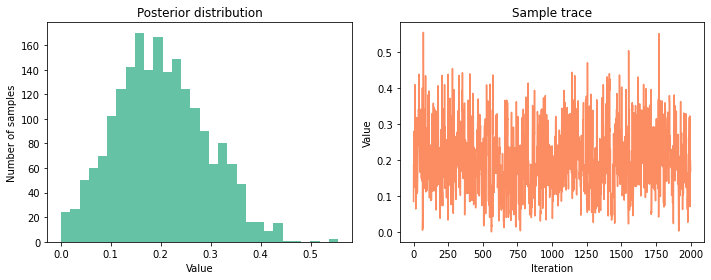

In [18]:
# We know that p_true = 0.5 * p_visible + 0.25 or p_visible = 2 * (p_true - 0.25)
# so we would expect p_visible to be around at 0.2 = 2 * (0.35 - 0.25)
plot_samples(mcmc_samples["p"])

## Challenger Disaster

In [19]:
challenger_data = requests.get(
    "https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv"
)

In [20]:
challenger_data = np.genfromtxt(
    io.StringIO(challenger_data.text),
    skip_header=1,
    usecols=[1, 2],
    missing_values="NA",
    delimiter=",",
)
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

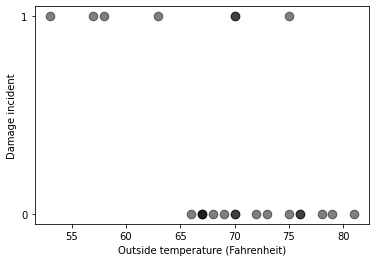

In [21]:
fig, ax = plt.subplots()

ax.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k", alpha=0.5)
ax.set_yticks([0, 1])
ax.set_ylabel("Damage incident")
ax.set_xlabel("Outside temperature (Fahrenheit)")

plt.show()

In [22]:
temperatures = torch.tensor(challenger_data[:, 0], dtype=torch.float64)
failures = torch.tensor(challenger_data[:, 1], dtype=torch.float64)

In [23]:
def challenger_model(temperatures, failures):
    alpha = pyro.sample("alpha", dist.Normal(0, 10))
    beta = pyro.sample("beta", dist.Normal(0, 10))

    logits = alpha + beta * temperatures

    with pyro.plate("plate", temperatures.shape[0]):
        pyro.sample("failures", dist.Bernoulli(logits=logits), obs=failures)

In [24]:
nuts_kernel = NUTS(challenger_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=400)
mcmc.run(temperatures, failures)

Sample: 100%|██████████| 2400/2400 [01:29, 26.68it/s, step size=7.28e-02, acc. prob=0.939]


In [25]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

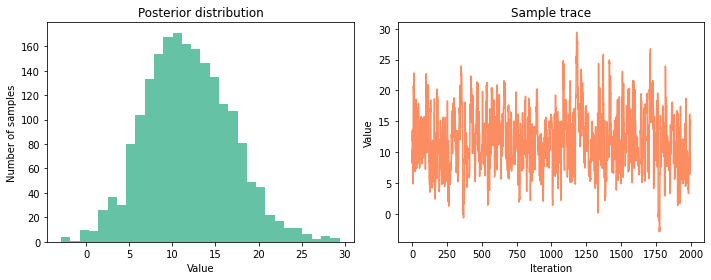

In [26]:
plot_samples(mcmc_samples["alpha"])

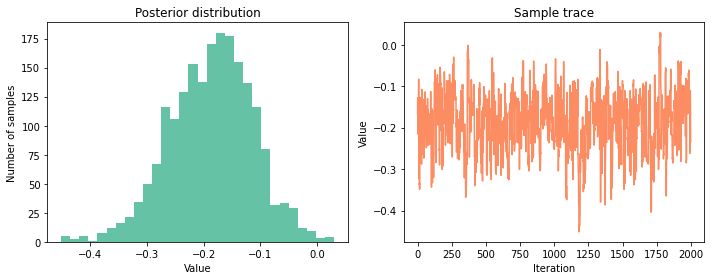

In [27]:
plot_samples(mcmc_samples["beta"])

In [28]:
# Let's generate some samples for the whole temperature range
predictor = Predictive(challenger_model, mcmc.get_samples(), return_sites=["alpha", "beta"], parallel=True)

new_temperatures = torch.linspace(50, 85, 100)
new_samples = predictor.get_samples(new_temperatures, None)
new_logits = new_samples["alpha"] + new_samples["beta"] * new_temperatures
new_probs = 1 / (1 + torch.exp(-new_logits))

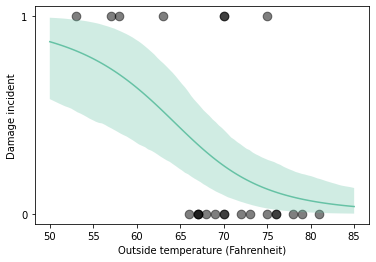

In [29]:
# We can now plot the prediction and 90% credible interval (colored area)
fig, ax = plt.subplots()

ax.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k", alpha=0.5)
ax.set_yticks([0, 1])
ax.set_ylabel("Damage incident")
ax.set_xlabel("Outside temperature (Fahrenheit)")

ax.fill_between(new_temperatures, new_probs.quantile(0.05, axis=0), new_probs.quantile(0.95, axis=0), alpha=0.3)
ax.plot(new_temperatures, new_probs.mean(axis=0))

plt.show()